# Github Connections


### Set up

Import libraries

In [2]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta  # Make sure to import this
import requests
import concurrent.futures
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import os
import base64
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import time


/Users/yanvansnippenburg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Load global vars

In [3]:
# Load variables from .env file
load_dotenv()

# Access the environment variables
GITHUB_REPO = os.getenv("GITHUB_REPO")
GITHUB_BRANCH = os.getenv("GITHUB_BRANCH")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
api_key = os.getenv("API_KEY")

## Temperature data and locations functions

Fetch daily temp data, lat long based

In [8]:
'''
Function 
inputs:
lat, lon: Latitude and Longitude of the location
start, end: Start and end dates in "YYYY-MM-DD" format

Outputs:
DataFrame containing daily temperature and precipitation data from NASA POWER API.

'''

def get_nasa_power_weather(lat, lon, months=6):

    end_date = datetime.today()
    start_date = end_date - relativedelta(weeks=months)

    start_dt = start_date.strftime("%Y%m%d")
    end_dt = end_date.strftime("%Y%m%d")

    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?"
        f"start={start_dt}&end={end_dt}&latitude={lat}&longitude={lon}"
        f"&community=SB&parameters=T2M,PRECTOT&format=JSON"
    )

    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API request failed: {response.status_code}")

    data = response.json()

    try:
        param_data = data['properties']['parameter']
        temp_data = param_data.get("T2M", {})
        precip_data = param_data.get("PRECTOT", {})

        if not temp_data:
            raise Exception("Temperature (T2M) data missing")
        
        dates = list(temp_data.keys())
        df = pd.DataFrame({
            "date": pd.to_datetime(dates),
            "Temperature_C": list(temp_data.values()),
            "Precipitation_mm": [precip_data.get(d, None) for d in dates],
        })

        df.set_index("date", inplace=True)
        return df

    except Exception as e:
        print("Raw API data:", data)
        raise Exception(f"Data parsing failed: {e}")

Import all places with coordinates


In [ ]:
# Column names from GeoNames documentation
columns = [
    "geonameid", "name", "asciiname", "alternatenames",
    "latitude", "longitude", "feature_class", "feature_code",
    "country_code", "cc2", "admin1_code", "admin2_code",
    "admin3_code", "admin4_code", "population", "elevation",
    "dem", "timezone", "modification_date"
]

# Load file
coord_data = pd.read_csv("VN.txt", sep="\t", names=columns, dtype=str)

# Convert lat/lon and population to numeric
coord_data["latitude"] = pd.to_numeric(coord_data["latitude"])
coord_data["longitude"] = pd.to_numeric(coord_data["longitude"])
coord_data["population"] = pd.to_numeric(coord_data["population"])

Allows for city based coords

In [10]:
'''
Function: get_nasa_power_weather

Inputs:
- lat (float): Latitude of the location (e.g., 10.03 for Can Tho)
- lon (float): Longitude of the location (e.g., 105.78 for Can Tho)
- start (str): Start date in "YYYY-MM-DD" format
- end (str): End date in "YYYY-MM-DD" format

Output:
- DataFrame: Contains daily temperature (°C) and precipitation (mm) data 
  for the specified location and time range, retrieved from the NASA POWER API.
'''

# Ensure numeric types before calling function (do this once)
coord_data["latitude"] = pd.to_numeric(coord_data["latitude"], errors="coerce")
coord_data["longitude"] = pd.to_numeric(coord_data["longitude"], errors="coerce")
coord_data["population"] = pd.to_numeric(coord_data["population"], errors="coerce").fillna(0).astype(int)

def get_lon_lat_data(place_name, df=coord_data):
    """
    Returns latitude, longitude, population, and geonameid for a given place name (case-insensitive).
    If multiple matches exist, returns the top one with highest population.
    """
    place_name = place_name.lower()

    # Filter rows where name matches place_name (case-insensitive)
    matches = df[df["name"].str.lower() == place_name]

    if matches.empty:
        return None  # or raise Exception("Place not found")

    # Sort by population descending and pick top one
    best_match = matches.sort_values("population", ascending=False).iloc[0]

    return (
        float(best_match["latitude"]),
        float(best_match["longitude"]),
        int(best_match["population"]),
        best_match["geonameid"]
    )


Import the current weather situation

In [ ]:
def get_current_weather(city):
    lat, lon, _, _ = get_lon_lat_data(city)  

In [ ]:
def get_weather(city, api_key=api_key):
    lon, lat, _, _ = get_lon_lat_data(city)
    if lon is None or lat is None:
        lon, lat = 106.660172, 10.762622  # Default to Ho Chi Minh City if not found
    url = (
        f"https://api.openweathermap.org/data/2.5/weather?"
        f"lat={lat}&lon={lon}&appid={api_key}&units=metric"
    )
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200:
        temp = data['main']['temp']  # Temperature in Celsius
        # Precipitation can be in 'rain' or 'snow' field, depends on weather
        precipitation = 0
        if 'rain' in data and '1h' in data['rain']:
            precipitation = data['rain']['1h']  # mm of rain in last 1 hour
        elif 'snow' in data and '1h' in data['snow']:
            precipitation = data['snow']['1h']  # mm of snow in last 1 hour

        return temp, precipitation
    else:
        print(f"Error fetching data: {data.get('message', 'Unknown error')}")
        return None, None

temperature, precipitation = get_weather("Ho Chi Minh City", api_key)
print(f"Temperature: {temperature}°C")
print(f"Precipitation in last hour: {precipitation} mm")

Error fetching data: wrong latitude
Temperature: None°C
Precipitation in last hour: None mm


In [ ]:
def get_weather_history_by_coords(city, api_key=api_key):
    lat, lon, _, _ = get_lon_lat_data(city)
    if lat is None or lon is None:
        lat, lon = 10.762622, 106.660172  # Default to Ho Chi Minh City if not found

    # Convert current time and start of the day to UNIX timestamps
    end_time = int(time.time())  # now
    start_time = int(datetime.now().replace(hour=0, minute=0, second=0, microsecond=0).timestamp())

    url = (
        f"http://history.openweathermap.org/data/2.5/history/city?"
        f"lat={lat}&lon={lon}&type=hour&start={start_time}&end={end_time}&appid={api_key}&units=metric"
    )

    #print("Requesting:", url)
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and 'list' in data:
        temps = []
        precips = []
        for hour_data in data['list']:
            temps.append(hour_data['main']['temp'])

            precip = 0
            if 'rain' in hour_data and '1h' in hour_data['rain']:
                precip += hour_data['rain']['1h']
            if 'snow' in hour_data and '1h' in hour_data['snow']:
                precip += hour_data['snow']['1h']
            precips.append(precip)

        avg_temp = sum(temps) / len(temps) if temps else None
        total_precip = sum(precips) if precips else 0

        return avg_temp, total_precip
    else:
        print("Error:", data.get("message", "Unknown error"))
        return None, None

# Example: Ho Chi Minh City
lat = 10.762622
lon = 106.660172
temperature, precipitation = get_weather_history_by_coords("Ho Chi Minh City")
print(f"Average Temp Today: {temperature:.2f}°C")
print(f"Total Precip Today: {precipitation:.2f} mm")

Average Temp Today: 30.47°C
Total Precip Today: 5.31 mm


### Define the selected variables (change)

Define the selected cities and periods, the can be changed and extended. Run all thereafter


In [14]:
selected_cities = ["Hanoi", "Western Region", "Ho Chi Minh City", "Red River Delta"] #Selected cities as start # maybe 7 largest cities?
selected_periods = [1, 3, 6]  # in months #other timeframes

## Upload the Temp Data

### Define functions

In [16]:
def upload_to_github(filepath, repo_path):
    import base64
    import requests

    with open(filepath, "rb") as f:
        content = f.read()

    b64_content = base64.b64encode(content).decode()

    # Correctly use your variables here
    url = f"https://api.github.com/repos/{GITHUB_REPO}/contents/{repo_path}"
    headers = {
        "Authorization": f"token {GITHUB_TOKEN}",
        "Accept": "application/vnd.github.v3+json"
    }

    # Check if file exists
    response = requests.get(url, headers=headers)

    data = {
        "message": f"Upload plot {repo_path}",
        "content": b64_content,
        "branch": GITHUB_BRANCH,
    }

    if response.status_code == 200:
        data["sha"] = response.json().get("sha")
    elif response.status_code != 404:
        print(f"GitHub API error: {response.status_code} {response.text}")
        return None

    # Upload file
    put_response = requests.put(url, headers=headers, json=data)

    if put_response.status_code in [200, 201]:
        print(f"Successfully uploaded {repo_path}")
        raw_url = f"https://raw.githubusercontent.com/{GITHUB_REPO}/{GITHUB_BRANCH}/{repo_path}"
        return raw_url
    else:
        print(f"Failed to upload {repo_path}: {put_response.status_code} {put_response.text}")
        return None

In [48]:
def fetch_and_upload(city, months):
    # Get coordinates
    coords = get_lon_lat_data(city)
    if coords is None:
        print(f"Coordinates not found for {city}")
        return None
    lat, lon, _, _ = coords

    # Fetch NASA POWER weather data
    df = get_nasa_power_weather(lat, lon, months=months)
    if df.empty:
        print(f"No data for {city} for last {months} month(s)")
        return None
    df = df[df["Temperature_C"] > 0]
    # Prepare plot
    period_text = f"{months}_months"
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["Temperature_C"], label="Temperature (°C)", color='tab:red')
    plt.title(f"Daily Temperature in {city} ({period_text})")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.tight_layout()

    # Filename and save path
    filename = f"forecast_graph_{city.replace(' ', '_').lower()}_{period_text.replace(' ', '_')}.png"
    current_dir = os.getcwd()
    local_path = os.path.join(current_dir, filename)
    plt.savefig(local_path, dpi=300)
    plt.close()
    # Upload to GitHub repo in graphs/ folder
    repo_path = f"graphs/{filename}"
    print(repo_path)
    url = upload_to_github(local_path, repo_path)

    # Optional: delete local file if you want to keep clean
    os.remove(local_path)

    return url


### Generate data and upload to Github

In [18]:
# Run for all cities and periods
for city in selected_cities:
    for months in selected_periods:
        print(f"Processing {city} for {months} month(s)...")
        uploaded_url = fetch_and_upload(city, months)

Processing Hanoi for 1 month(s)...
graphs/forecast_graph_hanoi_1_months.png
Successfully uploaded graphs/forecast_graph_hanoi_1_months.png
Processing Hanoi for 3 month(s)...
graphs/forecast_graph_hanoi_3_months.png
Successfully uploaded graphs/forecast_graph_hanoi_3_months.png
Processing Hanoi for 6 month(s)...
graphs/forecast_graph_hanoi_6_months.png
Successfully uploaded graphs/forecast_graph_hanoi_6_months.png
Processing Western Region for 1 month(s)...
graphs/forecast_graph_western_region_1_months.png
Successfully uploaded graphs/forecast_graph_western_region_1_months.png
Processing Western Region for 3 month(s)...
graphs/forecast_graph_western_region_3_months.png
Successfully uploaded graphs/forecast_graph_western_region_3_months.png
Processing Western Region for 6 month(s)...
graphs/forecast_graph_western_region_6_months.png
Successfully uploaded graphs/forecast_graph_western_region_6_months.png
Processing Ho Chi Minh City for 1 month(s)...
graphs/forecast_graph_ho_chi_minh_city_

In [19]:
# Collect weather data
weather_data_today = []

for city in selected_cities:
        temp, precip = get_weather_history_by_coords(city)
        weather_data_today.append({
            "city": city,
            "temperature": temp,
            "precipitation": precip
        })
folder = "climate_data"
os.makedirs(folder, exist_ok=True)

weather_data_today = pd.DataFrame(weather_data_today)

save_file_path = os.path.join(folder, "weather_data_today.csv")
weather_data_today.to_csv(save_file_path, index=False)

# Upload to GitHub
upload_to_github(save_file_path, "climate_data/weather_data_today.csv")

# Clean up
os.remove(save_file_path)
if not os.listdir(folder):
    os.rmdir(folder)

Successfully uploaded climate_data/weather_data_today.csv


### Scalability folder updates

Upload the list selected cities to github

In [ ]:
# Ensure the folder exists
folder = "scalability"
os.makedirs(folder, exist_ok=True)

# Write the cities list to a file
save_file_path = os.path.join(folder, "selected_cities.txt")
with open(save_file_path, "w") as f:
    f.write(str(selected_cities))  # Stored as string representation of list

upload_to_github(save_file_path, "scalability/selected_cities.txt")    

os.remove(save_file_path)

# Optionally delete the folder if empty
if not os.listdir(folder):
    os.rmdir(folder)

Successfully uploaded scalability/selected_cities.txt


Upload the selected periods to Github

In [ ]:
# Ensure the folder exists
folder = "scalability"
os.makedirs(folder, exist_ok=True)

# Write the cities list to a file
save_file_path = os.path.join(folder, "selected_periods.txt")
with open(save_file_path, "w") as f:
    f.write(str(selected_periods))  # Stored as string representation of list

upload_to_github(save_file_path, "scalability/selected_periods.txt")    

os.remove(save_file_path)

# Optionally delete the folder if empty
if not os.listdir(folder):
    os.rmdir(folder)

Successfully uploaded scalability/selected_periods.txt


## Crop information 

Make the crop selection (scalable)

In [21]:
selected_crops = ["Rice", "Maize", "Sugar cane"]

extend the folder scalability

In [23]:
# Ensure the folder exists
folder = "scalability"
os.makedirs(folder, exist_ok=True)

# Write the cities list to a file
save_file_path = os.path.join(folder, "selected_crops.txt")
with open(save_file_path, "w") as f:
    f.write(str(selected_crops))  # Stored as string representation of list

upload_to_github(save_file_path, "scalability/selected_crops.txt")    

os.remove(save_file_path)

# Optionally delete the folder if empty
if not os.listdir(folder):
    os.rmdir(folder)

Successfully uploaded scalability/selected_crops.txt


## Crop prices

In [24]:
CropPrices = np.random.lognormal(mean=3, sigma=1, size=len(selected_crops))

# Create DataFrame
crop_prices = pd.DataFrame({
    "crop": selected_crops,
    "price": CropPrices
})

# Save to CSV
folder = "price_data"
os.makedirs(folder, exist_ok=True)


save_file_path = os.path.join(folder, "crop_prices.csv")
crop_prices.to_csv(save_file_path, index=False)

# Upload to GitHub
upload_to_github(save_file_path, "price_data/crop_prices.csv")

# Clean up
os.remove(save_file_path)
if not os.listdir(folder):
    os.rmdir(folder)

Successfully uploaded price_data/crop_prices.csv


#### Historical prices for all crops

In [25]:
# webscrape 

'''
    print(f"Fetching price data for {crop}...")
    # Implement web scraping logic here to fetch the price data for each crop
    # For example, you can use BeautifulSoup or Scrapy to scrape a website
    # and then save the data in a similar DataFrame format as above.
period = 6 #months
end_date = datetime.today()
start_date = end_date - relativedelta(months=period)


for crop in selected crops:
    fetch_and_upload(crop, start_date, end_date)   
    dict = {date: price for date} 
    save dict as 
    f"historical_prices_{crop}.csv"
'''


'\n    print(f"Fetching price data for {crop}...")\n    # Implement web scraping logic here to fetch the price data for each crop\n    # For example, you can use BeautifulSoup or Scrapy to scrape a website\n    # and then save the data in a similar DataFrame format as above.\nperiod = 6 #months\nend_date = datetime.today()\nstart_date = end_date - relativedelta(months=period)\n\n\nfor crop in selected crops:\n    fetch_and_upload(crop, start_date, end_date)   \n    dict = {date: price for date} \n    save dict as \n    f"historical_prices_{crop}.csv"\n'

Place Holder, AR(1) price simulation

In [ ]:

def simulate_and_upload_prices(crop, period=6, end_date=datetime.today(), initial_price=np.random.lognormal(mean=3, sigma=0.1, size=1)):
    """
    Simulate daily prices over the given date range with an AR(1)-like process:
    price_t = price_{t-1} + Normal(0,1)
    Save to CSV, upload to GitHub, then remove local file.
    
    crop: str, crop name
    start_date: datetime, simulation start
    end_date: datetime, simulation end
    initial_price: float, starting price at start_date
    upload_func: function, handles uploading file to GitHub, takes (local_path, remote_path)
    """
    start_date = end_date - relativedelta(months=period)

    # Create daily date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(dates)
    
    # Simulate daily price changes (normal noise)
    noise = np.random.normal(loc=0, scale=0.1, size=n_days)
    
    # Create price series as cumulative sum of noise starting from initial price
    prices = initial_price + np.cumsum(noise)
    
    # Make sure prices are positive (optional)
    prices = np.clip(prices, a_min=0.01, a_max=None)
    
    # Plot prices
    plt.figure(figsize=(10, 6))
    plt.plot(dates, prices, label=f"{crop} Price")
    plt.title(f"Simulated Daily Prices for {crop} ({period} months)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    # Save plot as PNG
    folder = "price_plots"
    os.makedirs(folder, exist_ok=True)
    plot_file = f"price_plot_{crop.lower().replace(' ', '_')}.png"
    plot_path = os.path.join(folder, plot_file)
    plt.savefig(plot_path)
    plt.close()

    # Upload plot image to GitHub
    upload_to_github(plot_path, f"price_data/{plot_file}")

    # Clean up local file
    os.remove(plot_path)
    if not os.listdir(folder):
        os.rmdir(folder)

    print(f"Plot uploaded for {crop}")

# Define simulation period (6 months)
end_date = datetime.today()
period = 6  # months

# Example selected crops and their initial prices (from your cropPrices dict or elsewhere)
initial_price = dict(zip(crop_prices["crop"], crop_prices["price"]))

for crop in selected_crops:
    simulate_and_upload_prices(crop, period, end_date, initial_price[crop])

Successfully uploaded price_data/price_plot_rice.png
Plot uploaded for Rice
Successfully uploaded price_data/price_plot_maize.png
Plot uploaded for Maize
Successfully uploaded price_data/price_plot_sugar_cane.png
Plot uploaded for Sugar cane


## Crop Advice Info

### Crop advice uploads

Upload function

In [ ]:
def text_upload(crop, type, text):
    """
    Uploads text data to GitHub in the specified format.
    
    crop: str, crop name
    type: str, type of text data (e.g., 'description', 'instructions')
    text: str, content to upload

    format:
    advice_{type}_{crop}.txt
    """
    folder = "text_data"
    os.makedirs(folder, exist_ok=True)
    
    filename = f"advice_{type}_{crop.lower().replace(' ', '_')}.txt"
    file_path = os.path.join(folder, filename)
    
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(text)
    
    upload_to_github(file_path, f"texts/{filename}")
    
    # Clean up local file
    os.remove(file_path)

    if not os.listdir(folder):
        os.rmdir(folder)

### Cultivation tips

In [ ]:
text_upload(
    "Rice",
    "cul", 
    "Welcome to the basic rice farming guide: \n"
    "\n"
    "This guide gives simple steps to help you grow rice successfully, even in challenging conditions. \n"
    "\n"
    "1. Choose Good Seeds \n"
    "- Use clean and healthy seeds. \n"
    "- Get them from trusted sources to ensure strong plants. \n"
    "\n"
    "2. Prepare Your Land \n"
    "- Level your field so water spreads evenly. \n"
    "- Remove weeds and leftover plants from the last season. \n"
    "- Use compost or animal manure to improve the soil. \n"
    "\n"
    "3. Plant at the Right Time \n"
    "- Transplant rice seedlings 20–25 days after sowing. \n"
    "\n"
    "4. Use Water Wisely \n"
    "- Keep water 2–5 cm deep in the field while the rice is growing. \n"
    "\n"
    "5. Use Fertiliser Correctly \n"
    "- Apply fertiliser when rice is growing and when grains start forming. \n"
    "\n"
    "6. Harvest at the Right Time \n"
    "- Harvest when about 85 percent of the grains are yellow. \n"
    "- Do not wait too long—grains may fall to the ground. \n"
    "\n"
    "Tip: If your field has salty water (common in southern Vietnam), use salt-tolerant rice varieties. \n"
    )

In [39]:
text_upload(
    "Maize",
    "cul",
    "Welcome to the basic maize farming guide: \n"
    "\n"
    "This guide helps you grow healthy maize plants and improve your harvest. \n"
    "\n"
    "1. Choose Good Seeds \n"
    "- Select high-yield and drought-tolerant maize varieties. \n"
    "- Use certified seeds from trusted suppliers. \n"
    "\n"
    "2. Prepare the Land \n"
    "- Plough the land well and break large soil clumps. \n"
    "- Add compost or manure before planting to enrich the soil. \n"
    "\n"
    "3. Plant at the Right Time \n"
    "- Plant just before or at the start of the rainy season. \n"
    "- Leave 25–30 cm between plants and 70–90 cm between rows. \n"
    "\n"
    "4. Use Water Wisely \n"
    "- Maize needs more water during flowering and grain-filling stages. \n"
    "- Avoid waterlogging—ensure good drainage. \n"
    "\n"
    "5. Use Fertiliser Correctly \n"
    "- Apply nitrogen-rich fertiliser when plants are knee-high. \n"
    "- Apply again when tassels appear. \n"
    "\n"
    "6. Harvest at the Right Time \n"
    "- Harvest when cobs are dry and kernels are hard (husks turn brown). \n"
    "- Dry the maize properly to avoid mold. \n"
    )

Successfully uploaded texts/advice_cul_maize.txt


In [40]:
text_upload(
    "Sugarcane",
    "cul",
    "Welcome to the basic sugarcane farming guide: \n"
    "\n"
    "This guide gives steps to help you grow healthy sugarcane and increase profits. \n"
    "\n"
    "1. Choose Good Planting Material \n"
    "- Use healthy, disease-free cane stalks (2–3 buds each). \n"
    "- Choose varieties suited to your region. \n"
    "\n"
    "2. Prepare the Land \n"
    "- Deep plough the field to loosen the soil. \n"
    "- Add compost or manure to enrich the land. \n"
    "- Make ridges or furrows for planting. \n"
    "\n"
    "3. Plant at the Right Time \n"
    "- Best time: end of dry season or start of rainy season. \n"
    "- Place cane stalks horizontally in furrows and cover with soil. \n"
    "\n"
    "4. Use Water Wisely \n"
    "- Keep soil moist, especially in the first 60–90 days. \n"
    "- Use furrow irrigation if available; avoid waterlogging. \n"
    "\n"
    "5. Use Fertiliser Correctly \n"
    "- Apply nitrogen and potash 30–45 days after planting. \n"
    "- Repeat after 3 months. \n"
    "\n"
    "6. Harvest at the Right Time \n"
    "- Harvest 10–12 months after planting (depending on variety). \n"
    "- Look for dry leaves, swollen internodes, and sweet juice. \n"
    )

Successfully uploaded texts/advice_cul_sugarcane.txt


### PnD advice 

In [41]:

text_upload(
    "Rice",
    "pnd",
    "To protect your rice from pests and diseases, remember: \n"
    "\n"
    "- Watch for insects like brown planthopper and diseases like leaf spots. \n"
    "- Use natural methods or approved chemicals to control pests safely. \n"
    "- Check your fields often for discolored spots — early detection helps prevent spread. \n"
    "- Avoid using too much fertiliser, especially nitrogen, as it can increase pests. \n"
    "- After harvest, burn or remove diseased plant debris to stop pests from returning. \n"
    )


Successfully uploaded texts/advice_pnd_rice.txt


In [42]:
text_upload(
    "Maize",
    "pnd",
    "To protect your maize from pests and diseases, follow these tips: \n"
    "\n"
    "- Look out for pests like stem borers, armyworms, and aphids. \n"
    "- Watch for diseases such as leaf blight or rust spots. \n"
    "- Use natural predators, crop rotation, or safe pesticides to control pests. \n"
    "- Inspect your crop regularly for damaged leaves or unusual spots. \n"
    "- Avoid over-fertilizing with nitrogen, which can attract pests. \n"
    "- Remove or destroy infected plants and crop residues after harvest. \n"
    )

Successfully uploaded texts/advice_pnd_maize.txt


In [43]:
text_upload(
    "Sugarcane",
    "pnd",
    "To keep sugarcane healthy and free from pests and diseases: \n"
    "\n"
    "- Watch for pests like sugarcane borers and aphids. \n"
    "- Look for diseases such as red rot or leaf scald (discolored or dead patches). \n"
    "- Use natural control methods or recommended pesticides carefully. \n"
    "- Check fields often for signs of pest damage or disease symptoms. \n"
    "- Avoid excess nitrogen fertiliser, which can encourage pest problems. \n"
    "- After harvest, remove or burn diseased stalks and plant debris. \n"
    )

Successfully uploaded texts/advice_pnd_sugarcane.txt


## Weather Advice

#### Weather advice rain

advice under avg rain

In [ ]:
text_upload(
    "rain0",
    "weather",
    ""
    )

advice avg rain


In [ ]:
text_upload(
    "rain1",
    "weather",
    ""
    )

advice above avg rain 

In [ ]:
text_upload(
    "rain2",
    "weather",
    ""
    )

#### Weather wind advice

advice for under avg wind

In [ ]:
text_upload(
    "wind0",
    "weather",
    ""
    )

advice for avg wind


In [ ]:
text_upload(
    "wind1",
    "weather",
    ""
    )

advice for above avg wind

In [ ]:
text_upload(
    "wind2",
    "weather",
    ""
    )

#### Weather temp advice

advice for under avg weather temp

In [ ]:
text_upload(
    "temp0",
    "weather",
    ""
    )

advice for avg weather temp

In [ ]:
text_upload(
    "temp1",
    "weather",
    ""
    )

advice for above avg weather temp

In [ ]:
text_upload(
    "temp2",
    "weather",
    ""
    )

### Upload the GAP AND SBS, (Revise)

Do the text of step by step, #send a picture if not data saving, for illustrations. 


In [ ]:
text_upload(
    "SBS",
    "guide",
    "Welcome to the information of a step by step guide for conservation agriculture \n"
    "\n"
    "Step 1: Field Lay Out \n"
    "All crop rows should be 65 cm apart from each other, and the distance between the crops in each row should be 75 cm.\n"
    "If the area is dry, increase the row spacing to 78 cm and crop spacing to 90 cm.\n"
    "To do this effectively, use a piece of rope for the measurements. \n"
    "\nStep 2: The Baisins "
    "\n"
    "The baisins should be 15 cm long, 8 cm wide and 10 cm deep \n"
    "\n Step 3: Fertiliser and Compost \n"
    "The fertiliser should be put in first, under the soil, use a 2 caps of a soda bottle of fertiliser per baisin. \n"
    "Then add compost, use a 2 hands of compost per baisin. \n"
) 
'''
calculations for a more efficient grid structure
(75**2-37.5**2)**.5 = 64.9519052838329

(90**2-45**2)**.5 = 77.94228634059948
'''

Successfully uploaded texts/advice_guide_sbs.txt


The three practices

In [35]:
text_upload(
    "3PGAP", 
    "guide", 
    "Welcome to the information page of the three main principles of conservation agriculture: \n"
    "\n" 
    "Principle 1: Minimal soil disturbance \n"
    "This means that the soil should not be ploughed or tilled, as this can damage the soil structure and lead to erosion. \n"
    "The advantages are: \n"
    "protectsion against wind and erosion: \n"
    "Improves the quality of the orgainic matter in the soil: \n"
    "Decreases the costs in the long term: \n"
    "Improves the water take up and retention. \n"
    "The fertiliser becomes more effective. \n"
    "\n"
    "Principle 2: Permanent soil cover with organic matters \n"
    "This means that the soil is covered with organic matter, such as crop residues or cover crops, to protect it from erosion and improve its fertility. \n"
    "Advantages: \n"
    "Protection from erosion from wind and water: \n"
    "It recycles the use of nutrients: \n"
    "Suppresses the growth of weeds (unwanted plants): \n"
    "Improves accumalation of organic matter, further enhancing the effect: \n"
    "\n"
    "Principle 3: Crop rotation and intercropping \n"
    "This means that different crops are grown in the same field after each other, to improve soil fertility and reduce pests and diseases. \n"
    "The effect is the best if the crops are different families, such as legumes and cereals. \n"
    "Advantages: \n"
    "Improves the soil fertility and structure: \n"
    "Reduces the risk of pests and diseases: \n"
    "Increases the water use: \n"
    "\n"
    "Disclaimer: These materials have been based on the materials commissioned by FAO Lesotho and the Ministry of Agriculture and Food Security with financial support " \
    "from the European Commission Humaitarian Aid and Civil Protection Directorate (ECHO) and OFDA in 2012. These materials were developed in coordination with, and endorsed by, " \
    "the Lesotho Conservation Agriculture National Task Force (LCANTF). Furthermore, the information is processed with the help of a LLM Github Copilot, which is not a human expert. " \

    )

Successfully uploaded texts/advice_guide_3pgap.txt


Introduction to conservation agriculture main menu


In [36]:
text_upload(
    "CA", 
    "guide", 
    "Welcome to the information page of conservation agriculture: \n"
    "\n"
    "Conservation agriculture is a farming system that aims to improve soil health and productivity while reducing environmental impact. It is important as the current climate is changing rapidly. "
    "\n Conservation agriculture helps adapting to unpredicatble climate and unpredictable rainfall, it provides more food security. \n"
    "\n"
    "\n The consequences of climate change are: \n"
    "1. Extreme temperatures \n"
    "2. Unpredictable rainfall \n"
    "3. Droughts \n"
    "4. Floods \n"
    "\n"
    "Besides conservation agriculture, there are other methods to adapt to climate change, such as water tanks to always have water available, irrigation systems to efficiently water the crops, "
    "and crop diversification. \n"
    "\n"
    "The three main principles of conservation agriculture are shown below. Click the button for more information.  \n"
    "1. Minimal soil disturbance \n"
    "2. Permanent soil cover with organic matters \n"
    "3. Crop rotation and intercropping \n"
    "\n"
    "A step by step guide is available to help you implement conservation agriculture in your farm. \n"
      )

Successfully uploaded texts/advice_guide_ca.txt


Alternative cultivation techniques-aqua rice farming

In [38]:
text_upload(
    "RiceAquaculture",
    "guide",
    "Welcome to the information page of rice–aquaculture systems: \n"
    "\n"
    "Rice–aquaculture systems are farming methods that combine rice growing with raising aquatic animals like shrimp or fish. "
    "These systems help farmers adapt to climate change, improve soil health, and increase income. \n"
    "\n"
    "This method is especially useful as the climate becomes more unpredictable, with: \n"
    "1. Salty water during dry seasons \n"
    "2. Unpredictable rainfall \n"
    "3. Flooding and drought \n"
    "\n"
    "There are two main types of rice–aquaculture systems used in Vietnam: \n"
    "\n"
    "1. Rice–Shrimp Rotation: \n"
    "- Suitable for areas with seasonal salinity (saltwater). \n"
    "- Shrimp are raised in the dry season when water is salty. \n"
    "- In the rainy season, rainwater cleans the soil and prepares it for rice. \n"
    "- Shrimp waste gives nutrients to the rice. \n"
    "- Rice helps loosen and clean the soil for the next shrimp season. \n"
    "- This system is common in the Mekong Delta. \n"
    "\n"
    "2. Rice–Fish Co-Cultivation: \n"
    "- Rice and fish are grown in the same field. \n"
    "- Helps keep rice yields strong and provides fish for food and extra income. \n"
    "- Supports household food security. \n"
    "- Must be managed carefully to avoid environmental problems. \n"
    "\n"
    "The Vietnamese government (MARD) is helping farmers with policies to support integrated farming. \n"
    "- Farmers are encouraged to convert low-yield rice fields into rice–aquaculture areas. \n"
    "- These systems improve profitability and climate resilience. \n"
    "\n"
    "Below is a simple guide for rice–fish cultivation: \n"
    "\n"
    "Start of the rainy season (May–June): \n"
    "- Transplant rice as soon as the soil is moist. \n"
    "- After 2 weeks, when rice is stable, stock the fish. \n"
    "\n"
    "If heavy rain or flooding is expected: \n"
    "- Wait to plant rice and add fish until water is stable. \n"
    "\n"
    "In dry periods: \n"
    "- Water the rice regularly. \n"
    "- Shade the fish with floating plants. \n"
    "- Reduce fish feeding to prevent water stress. \n"
    "\n"
    "Before a storm or typhoon: \n"
    "- Harvest mature rice and fish early. \n"
    "- Move fish to safer ponds if possible. \n"
    "\n"
)

Successfully uploaded texts/advice_guide_riceaquaculture.txt


# Unused/old functions 

Faster Code

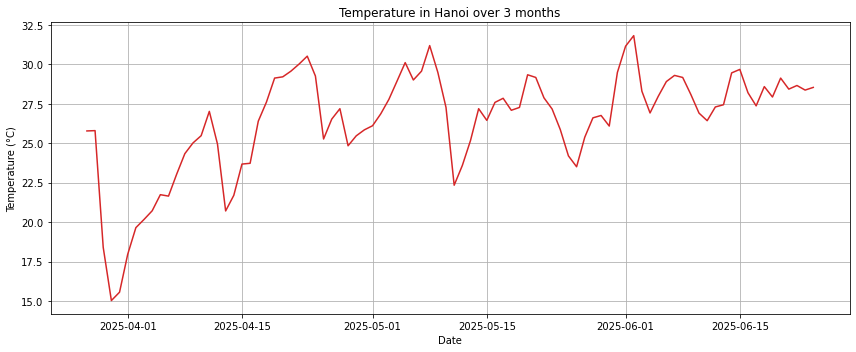